###Overview

This notebook is a variation of the Mamba Classification notebook which creates the classification model. The basic description is added below.\
However, this variation changes the evaluation process as follows:
1. It uses a generating Mamba model, which is run sequentially and can enter the model outputs as inputs to predict k steps ahead. The function 'generate_k_last_predictions' is added to the evaluation class for this.
2. The purpose of this research was to examine if predicting k steps forward provides a better distinction and leads to better classification. Thereore, we ran the process while evaluating on k= 1,2,3,4,5,10 and 20 and recorded all the results.
3. At the bottom of the notebook, all the results from the different k-experiments are loaded and compared. We find that k=1 generally gives the best results. Especially for the short length samples.
--------------------------------------------------------------
The general classification process is done by choosing the combination of class foreasting models that predicts the best classification score on the validation set. Here are the steps required for this:
1. We need to combine the **validation** sets of all classes to one big validation set used for classification evaluation.
2. We combine the **test** sets of all classes to one big test set used for final classification evaluation.
3. Define the evaluation class. This class receives a model and a set of samples for evaluation. It passes the samples through the model to receive predictions and evaluate the error of the trajectory. There are several options for the evaluation period. This period is also optimized on the validation set.
4. We load all the pandas dataframes that we have saved, containing all of the trained models paths and configurations. We combine to a unified dataframe.
5. 'get_validation_evaluation' - We want to compare the combinations of models using their errors to determine the classification. The comparison is done on the basis of a specific duration, say for a duration of 10 sec. We want to calculate the errors once and so we prepare a dictionary which saves the errors on all the 10 seconds samples from the validation set. The results are saved per model path.
6. 'get_best_combination' - We go through all combinations of models with one representitive per class. For each combination, we use the error of each model per sample to classify it. We obtain all the predictions and calculate the classification scores using the labels. We save the combination with the best f1-score for the UAV class.
7. Execute optimization for the best evaluation period for the chosen sample length to optimize. In the report we show different optimizations for 5 second samples vs. 30 second samples.
8. Using the best combination, do:\
  a. Final evaluation of errors for the class forecasting models on the test set. This is done for all sample durations.\
  b. Final classification using the errors of each class model.\
  c. Calculate performance (precision, recall, F1-score), using the class labels.\
  d. Show the metrics and confusion matrix for each duration.\
  e. Show bar plot with values

###Imports

In [ ]:
!pip install "pandas<2"

In [ ]:
# imports

import io
import glob
import os
import sys
from datetime import datetime
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# from scipy.fft import fft
import pandas as pd
from itertools import product
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

!pip install einops
# from __future__ import annotations
from dataclasses import dataclass
from einops import rearrange, repeat, einsum

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *
# from mamba_model import *
from mamba_model_generate import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 769.3 kB/s eta 0:00:00
Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [ ]:
subfolders = os.listdir("track_data/")
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

###Preparing test and validation samples

In [ ]:
# Here we combine the test samples from all different objects (subfolders)
# Each sample duration is combined separately so that we can evaluate separately for each duration
# The model returns the error averaged over the evaluation period

subfolders = ['airplane', 'uav', 'bird', 'static-object']
skips = [15, 15, 2, 40]
durations = [5, 10, 15, 20, 25, 30]
batch_size = 16

all_test_batches = {d:[] for d in durations}
all_test_labels = {d:[] for d in durations}
all_val_batches = {d:[] for d in durations}
all_val_labels = {d:[] for d in durations}
for subfolder, skip in zip(subfolders, skips):
  save_path = './Samples/mamba_samples_' + subfolder +'_skip'+ str(skip) +'_split0.2'+ '_all_samples'
  with open(save_path , 'rb') as f:
    (subfolder_train_data, subfolder_val_data, subfolder_test_data) = pickle.load(f)
    for dur, (samples, samples_filenames, dt, scales) in subfolder_test_data.items():
      if len(samples) > 0:
        subfolder_batches = []
        subfolder_labels = []
        dur_vec = [dur]*len(samples)
        data = list(zip(samples, dt, scales, dur_vec))

        dl = DataLoader(data, batch_size = batch_size, shuffle = False)
        for batch in dl:
          subfolder_batches.append(batch)

        # Note that the batches are not full so the labels are added as the original number of samples and not based on the number of batches
        subfolder_labels.extend([labels_dict[subfolder]] * len(samples))
        all_test_batches[dur].extend(subfolder_batches)
        all_test_labels[dur].extend(subfolder_labels)


    for dur, (samples, samples_filenames, dt, scales) in subfolder_val_data.items():
      if len(samples) > 0:
        subfolder_batches = []
        subfolder_labels = []
        dur_vec = [dur]*len(samples)
        data = list(zip(samples, dt, scales, dur_vec))

        dl = DataLoader(data, batch_size = batch_size, shuffle = False)
        for batch in dl:
          subfolder_batches.append(batch)

        # Note that the batches are not full so the labels are added as the original number of samples and not based on the number of batches
        subfolder_labels.extend([labels_dict[subfolder]] * len(samples))
        all_val_batches[dur].extend(subfolder_batches)
        all_val_labels[dur].extend(subfolder_labels)

###Evaluation class

In [ ]:
class EvaluatingGen(object):

  def __init__(self, model, config):
    self.config = config
    self.device = config['device']
    self.model = model.to(self.device)
    self.model.args.generate = True
    # self.model_path = config['model_path']
    self.criterion = nn.MSELoss(reduction='none').to(self.device)
    self.evaluation_length = int(config['evaluation_time']/config['delta'])
    self.evaluation_durations = config['evaluation_durations']

  def evaluate(self, dl_eval, k):
    self.k = k
    self.eval_results = {d:[] for d in self.evaluation_durations}
    self.epoch_eval_loss = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=True):
        self.eval_batch(batch)

  def eval_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)
    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)

    eval_loss = 0
    counter = 0
    for sample_length in range(samples.shape[1] - self.evaluation_length + self.k, samples.shape[1]+1):
      eval_sample = samples[:,:sample_length, :]
      eval_dt = dt[:, :sample_length]
      kplus1_predictions = self.generate_k_last_predictions(eval_sample, eval_dt)
      k_predictions = kplus1_predictions[:,:-1, :] #removes the last prediction with no label
      eval_labels = labels[:, :sample_length , :]
      k_labels = eval_labels[:, sample_length - self.k: , :]

      scaled_labels = einsum(k_labels, 1/scale, 'b l d, b d -> b l d')
      scaled_predictions = einsum(k_predictions, 1/scale, 'b l d, b d -> b l d')
      eval_loss = eval_loss + self.criterion(scaled_predictions, scaled_labels).mean((1,2)).cpu()
      counter += 1

    eval_loss = eval_loss/counter
    self.eval_results[int(dur[0])].extend(list(eval_loss))
    self.epoch_eval_loss += eval_loss.mean().item()

  def generate_k_last_predictions(self, sample, dt):
    self.model.args.reset_h()
    sample_header = sample[:, :-self.k, :]
    dt_header = dt[:, :-self.k]
    dt_tail = dt[:, -self.k:]
    with torch.no_grad():
      output = self.model(sample_header, dt_header)
      y = output[:, -1, :].unsqueeze(1) #generating from last prediction
      pred = [y]
      for i in range(self.k):
        single_dt = dt_tail[:, i].unsqueeze(1)
        y = self.model(y, single_dt)
        pred.append(y)
      predictions = torch.cat(pred, dim=1)
        # !note that the last prediction here does not have a label and should not be used. returning list of k+1 with only first k relevant
    return predictions

### Loading the information saved on all trained models

In [ ]:
field = 'Best Result @10' #Checking which models would have been chosen only on the basis of this field optimization
subfolders = ['airplane', 'uav', 'bird', 'static-object']
all_results_df = pd.DataFrame()
for subfolder in subfolders:
  prefix = './Mamba Training Results/mamba_training_results_split0.2_' + subfolder
  folder_results_df = pd.DataFrame()
  for file in glob.glob(prefix + '*'):
    print(file)
    with open(file, 'rb') as f:
      folder_results_df = folder_results_df.append(pickle.load(f))
  folder_results_df['Object'] = subfolder
  all_results_df = all_results_df.append(folder_results_df)
  all_results_df = all_results_df.drop_duplicates(field)
best_models = all_results_df.groupby('Object').apply(lambda x: x[x[field] == x[field].min()])
saved_models_path = best_models[['Object', 'Model Path']].set_index('Object').to_dict()['Model Path']

./Mamba Training Results/mamba_training_results_split0.2_airplane04_04_2024, 10:17:14
./Mamba Training Results/mamba_training_results_split0.2_airplane04_10_2024, 16:08:04
./Mamba Training Results/mamba_training_results_split0.2_airplane04_10_2024, 16:51:44
./Mamba Training Results/mamba_training_results_split0.2_airplane05_11_2024, 12:27:26
./Mamba Training Results/mamba_training_results_split0.2_airplane05_11_2024, 12:38:43
./Mamba Training Results/mamba_training_results_split0.2_uav04_04_2024, 11:45:41
./Mamba Training Results/mamba_training_results_split0.2_uav04_11_2024, 04:57:09
./Mamba Training Results/mamba_training_results_split0.2_uav05_11_2024, 08:16:04
./Mamba Training Results/mamba_training_results_split0.2_uav05_11_2024, 09:57:51
./Mamba Training Results/mamba_training_results_split0.2_bird04_04_2024, 07:58:22
./Mamba Training Results/mamba_training_results_split0.2_bird04_04_2024, 08:32:41
./Mamba Training Results/mamba_training_results_split0.2_static-object04_04_2024, 

In [ ]:
all_results_df

In [ ]:
best_models

####Evaluating all models on validation set with duration 10

In [ ]:
def evaluate_validation_on_all_models(all_results_df, all_val_batches, eval_dur, k):
  evaluation_config = {'batch_size': 32, 'device' : device, 'evaluation_time': 3, 'delta': 0.04, 'evaluation_durations': durations}
  validation_results = {}
  for i, row in all_results_df.iterrows():
    # print(row['Model Path'])
    # print(row['Mamba Config'])
    model_path = row['Model Path']
    state = torch.load(model_path, map_location=torch.device('cpu'))

    mamba_config = row['Mamba Config']
    # mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
    args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
    mamba_model = Mamba(args)

    mamba_model.load_state_dict(state['state_dict'])
    # Putting the model in generative mode to control intermediate outputs
    mamba_model.args.generate = True

    evaluating_mamba = EvaluatingGen(mamba_model, evaluation_config)
    evaluating_mamba.evaluate(all_val_batches[eval_dur], k)

    validation_results[model_path] = evaluating_mamba.eval_results
  return validation_results

In [ ]:
# validation_results = evaluate_validation_on_all_models(all_results_df, all_val_batches, eval_dur, k)

####Evaluate combinations of models
Get the best combination for UAV f1-score

In [ ]:
object_paths = all_results_df.groupby('Object')['Model Path'].apply(list)

In [ ]:
def find_best_combination_on_validation(validation_results, object_paths, all_val_labels, eval_dur):
  dur_labels = all_val_labels[eval_dur]
  best_uav_f1 = 0
  best_comb = None
  for a,b,c,d in product (object_paths['airplane'], object_paths['uav'], object_paths['bird'], object_paths['static-object']):
    # print(validation_results[a][eval_dur])
    errors = torch.stack((torch.tensor(validation_results[a][eval_dur]), torch.tensor(validation_results[b][eval_dur]), torch.tensor(validation_results[c][eval_dur]), torch.tensor(validation_results[d][eval_dur])))
    predicted_class = torch.argmin(errors, dim=0)
    report = classification_report(dur_labels, predicted_class, target_names=subfolders, output_dict = True)
    uav_f1 = report['uav']['f1-score']
    # print(uav_f1)
    if uav_f1 > best_uav_f1:
      best_uav_f1 = uav_f1
      best_comb = (a,b,c,d)
    return best_comb


In [ ]:
# best_comb = find_best_combination_on_validation(validation_results, object_paths, all_val_labels, eval_dur)
# best_comb

('./Models/mamba_model_airplane_dm8nl1ds32dc4rs42bs32opAdamlr0.05r105_11_2024, 12:27:26',
 './Models/mamba_model_uav_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 11:45:41',
 './Models/mamba_model_bird_dm8nl2ds16dc4rs42bs32opAdamlr0.05r104_04_2024, 07:58:22',
 './Models/mamba_model_static-object_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 13:50:05')

Evaluate using the best combination on the test data

---



In [ ]:
all_test = []
for dur in durations:
  all_test.extend(all_test_batches[dur])

def evaluate_best_comb_on_test(all_test, best_comb, k):
  evaluation_config = {'batch_size': 32, 'device' : device, 'evaluation_time': 3, 'delta': 0.04, 'evaluation_durations': durations} #can take delta from sample config
  flying_objects = ['airplane', 'uav', 'bird', 'static-object']
  eval_results_from_all_models = {}

  for f_object, model_path in zip(flying_objects, best_comb):
    state = torch.load(model_path, map_location=torch.device('cpu'))
    mamba_config = all_results_df.loc[all_results_df['Model Path'] == model_path]['Mamba Config'].values[0]
    args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
    mamba_model = Mamba(args)

    mamba_model.load_state_dict(state['state_dict'])

    evaluating_mamba = EvaluatingGen(mamba_model, evaluation_config)
    evaluating_mamba.evaluate(all_test, k)
    eval_results_from_all_models[f_object] = evaluating_mamba.eval_results
  return eval_results_from_all_models

###Classification evaluation

In [ ]:
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

In [ ]:
def get_classification_report(eval_results_from_all_models, all_test_labels):
  all_reports = {d:[] for d in durations}
  for dur in durations:
    dur_labels = all_test_labels[dur]
    errors = torch.full((len(subf_dict.keys()), len(dur_labels)), torch.inf)
    for f_object, eval_results in eval_results_from_all_models.items():
      if len(eval_results[dur]) > 0:
        errors[labels_dict[f_object]] = torch.tensor(eval_results[dur])
    predicted_class = torch.argmin(errors, dim=0)
    report = classification_report(dur_labels, predicted_class, target_names=eval_results_from_all_models.keys(), output_dict = True)
    # cm = confusion_matrix(dur_labels, predicted_class)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    #                             display_labels=flying_objects)
    # # cm = confusion_matrix(dur_labels, predicted_class, labels=flying_objects)
    all_reports[dur] = report
    # print(f'Results for sample duration of {dur} sec')
    # print(report)
    # disp.plot()
    # # disp.ax_.set_title(caption)
    # plt.show()
  return all_reports


#### Evaluation as a function of k forward predictions

In [ ]:
eval_dur = 10
# ks = [1, 2, 3, 4, 5, 10, 20]
ks = [10, 20]
summary_df = pd.DataFrame(columns = ['sample duration', 'evaluation time', 'k', 'metric', 'value'])
for k in ks:
  validation_results = evaluate_validation_on_all_models(all_results_df, all_val_batches, eval_dur, k)
  best_comb = find_best_combination_on_validation(validation_results, object_paths, all_val_labels, eval_dur)
  eval_results_from_all_models = evaluate_best_comb_on_test(all_test, best_comb, k)
  all_reports = get_classification_report(eval_results_from_all_models, all_test_labels)
  for d, report in all_reports.items():
    summary_df.loc[len(summary_df)] = [d, 3, k, 'precision', report['uav']['precision']]
    summary_df.loc[len(summary_df)] = [d, 3, k, 'recall', report['uav']['recall']]
    summary_df.loc[len(summary_df)] = [d, 3, k, 'f1-score', report['uav']['f1-score']]

In [ ]:
summary_df

,sample duration,evaluation time,k,metric,value
0,5,3,1,precision,0.833333
1,5,3,1,recall,0.963855
2,5,3,1,f1-score,0.893855
3,10,3,1,precision,0.873563
4,10,3,1,recall,0.938272
...,...,...,...,...,...
85,25,3,5,recall,0.915493
86,25,3,5,f1-score,0.935252
87,30,3,5,precision,0.983871
88,30,3,5,recall,0.897059


In [ ]:
summary_df

,sample duration,evaluation time,k,metric,value
0,5,3,10,precision,0.876543
1,5,3,10,recall,0.855422
2,5,3,10,f1-score,0.865854
3,10,3,10,precision,0.896104
4,10,3,10,recall,0.851852
5,10,3,10,f1-score,0.873418
6,15,3,10,precision,0.906667
7,15,3,10,recall,0.871795
8,15,3,10,f1-score,0.888889
9,20,3,10,precision,0.914286


In [ ]:
now = datetime.now()
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
date_time_ = str(date_time).replace("/","_")

In [ ]:
save_summary_df = './Mamba Classification Results/classification_summary_df' + date_time_
with open(save_summary_df , 'wb') as f:
    pickle.dump(summary_df, f)

###Process all samples

In [ ]:
summary_df_all_k = pd.DataFrame()
prefix = './Mamba Classification Results/classification_summary_df'
for file in glob.glob(prefix + '*'):
  print(file)
  with open(file, 'rb') as f:
    summary_df_all_k = summary_df_all_k.append(pickle.load(f))

./Mamba Classification Results/classification_summary_df05_17_2024, 18:08:01
./Mamba Classification Results/classification_summary_df05_17_2024, 20:39:26


In [ ]:
summary_df_all_k['k'] = summary_df_all_k['k'].astype(str)

In [ ]:
summary_df_all_k

,sample duration,evaluation time,k,metric,value,k-step,string k
0,5,3,1,precision,0.833333,1,1
1,5,3,1,recall,0.963855,1,1
2,5,3,1,f1-score,0.893855,1,1
3,10,3,1,precision,0.873563,1,1
4,10,3,1,recall,0.938272,1,1
...,...,...,...,...,...,...,...
31,25,3,20,recall,0.845070,20,20
32,25,3,20,f1-score,0.888889,20,20
33,30,3,20,precision,0.983333,20,20
34,30,3,20,recall,0.867647,20,20


In [ ]:
summary_df_all_k_f1 = summary_df_all_k.loc[summary_df_all_k.metric == "f1-score"]

In [ ]:
summary_df_all_k_f1

,sample duration,evaluation time,k,metric,value,k-step,string k
2,5,3,1,f1-score,0.893855,1,1
5,10,3,1,f1-score,0.904762,1,1
8,15,3,1,f1-score,0.904459,1,1
11,20,3,1,f1-score,0.946667,1,1
14,25,3,1,f1-score,0.929577,1,1
17,30,3,1,f1-score,0.934307,1,1
20,5,3,2,f1-score,0.863636,2,2
23,10,3,2,f1-score,0.877193,2,2
26,15,3,2,f1-score,0.869565,2,2
29,20,3,2,f1-score,0.890323,2,2


Text(33.48203472222223, 0.5, 'F1-score')

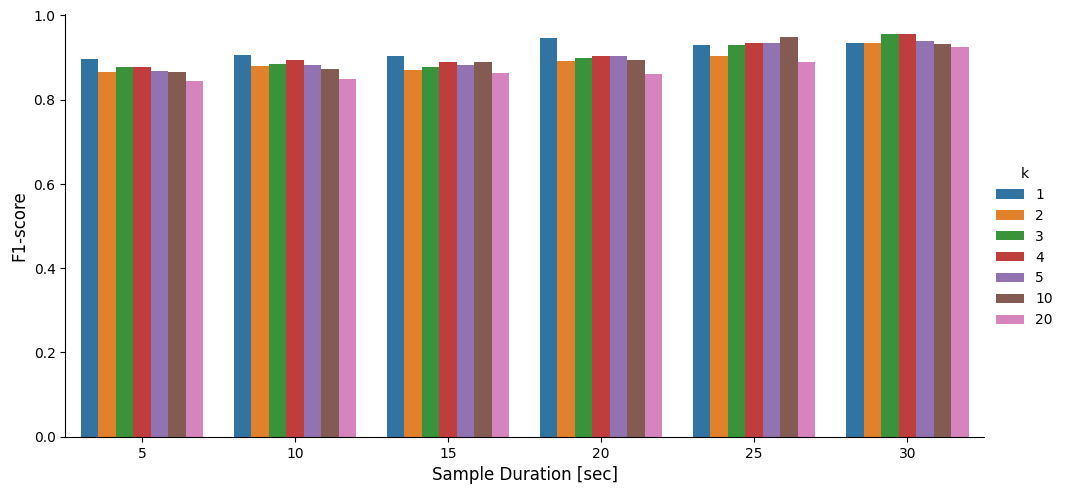

In [ ]:
# g = sns.catplot(data=summary_df_all_k_f1, x = "sample duration", y = "value", kind="bar", hue = "k", hue_order = ['1', '2', '3', '4', '5', '10', '20'], aspect = 2)
g = sns.catplot(data=summary_df_all_k, x = "sample duration", y = "value", kind="bar", hue = "k", aspect = 2, errorbar = None)

# for ax in g.axes.ravel():
#     for c in ax.containers:
#         labels = ['%0.2f' % v for v in c.datavalues]
#         ax.bar_label(c, labels=labels, label_type='edge')
#     # plt.xticks(rotation=45)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
#     ax.margins(y=0.2)
plt.xlabel('Sample Duration [sec]', fontsize = 12)
plt.ylabel('F1-score', fontsize = 12)